# Контекст
Продукт -  маркетплейс, запущенный в Бразилии, недавно появился на рынке.
Выручка маркетплейса стоит на месте несколько месяцев. 
Задача: изучить имеющиеся данные, оценить product market fit и сформулировать гипотезы, направденные на улучшение пользовательского опыта и максимизирующие прибыль компании



In [2]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors    
import numpy as np
%pip install Unidecode
import unidecode
%pip install folium
import folium
from IPython.display import IFrame
import plotly.express as px
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Файлы

### olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя
- customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)
- customer_zip_code_prefix — почтовый индекс пользователя
- customer_city — город доставки пользователя
- customer_state — штат доставки пользователя

In [4]:
customers = pd.read_csv('olist_customers_dataset.csv')

In [5]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [6]:
! pip install ydata-profiling
from ydata_profiling import ProfileReport

In [7]:
profile = ProfileReport(customers, title="Customers", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
customers.isna().sum()


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

### olist_orders_dataset.csv —  таблица заказов
- order_id — уникальный идентификатор заказа (номер чека)

- customer_id — позаказный идентификатор пользователя

- order_status — статус заказа

- order_purchase_timestamp — время создания заказа

- order_approved_at — время подтверждения оплаты заказа

- order_delivered_carrier_date — время передачи заказа в логистическую службу

- order_delivered_customer_date — время доставки заказа

- order_estimated_delivery_date — обещанная дата доставки

#### Уникальные статусы заказов в таблице olist_orders_dataset:

- created — создан;
- approved — подтверждён;
- invoiced — выставлен счёт;
- processing — в процессе сборки заказа;
- shipped — отгружён со склада;
- delivered — доставлен пользователю;
- unavailable — заказ отменён по причине недоступности товара;;
- canceled — отменён.

In [11]:
orders = pd.read_csv('olist_orders_dataset.csv'
        )

In [12]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [13]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [14]:
orders.shape

(99441, 8)

In [15]:
orders.order_id.nunique()

99441

### olist_order_items_dataset.csv — товарные позиции, входящие в заказы
- order_id — уникальный идентификатор заказа (номер чека)

- order_item_id — идентификатор товара внутри одного заказа

- product_id — ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price — цена за единицу товара

- freight_value — вес товара 

Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

In [18]:
items = pd.read_csv('olist_order_items_dataset.csv'
        )

In [19]:
items[items['order_id']=='00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


# Задачи
- Задача 1: Оценить месячный retention в оформление заказа с помощью когортного анализа.
- Задача 2: Определить, существует ли product/market fit у этого маркетплейса.
- Задача 3: Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании.
- Задача 4: Выбрать одну из 3-х основных гипотез с помощью фреймворка ICE.
- Задача 5: Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.
- Задача 6: Подготовить отчет о проделанной работе. По задаче 6 возможная оценка: 0-12 баллов.

## 0. Exploratiory analysis

In [22]:
# сколько на одного покупателя заказов?
cust2 = customers.groupby("customer_unique_id").agg({"customer_id":'count'}).astype(int)

In [23]:
cust2.query("customer_id > 1").count()*100/ cust2.query("customer_id == 1").count() 
#большинство клиентов оформили один заказ, клиентов с более чем один заказ около 3%

customer_id    3.219154
dtype: float64

In [24]:
orders_per_user = customers.groupby("customer_unique_id", as_index=False).agg(order_count = ('customer_id', 'count'))

In [25]:
orders_per_user.groupby("order_count",as_index=False).agg(customer_count=('customer_unique_id','count'))

,order_count,customer_count
0,1,93099
1,2,2745
2,3,203
3,4,30
4,5,8
5,6,6
6,7,3
7,9,1
8,17,1


In [26]:
sns.histplot(orders_per_user, x = 'order_count')

<Axes: xlabel='order_count', ylabel='Count'>

In [27]:
orders.customer_id.nunique()

99441

In [28]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [29]:
items.order_id.nunique() #общий объем заказов за весь период

98666

In [30]:
items_per_order = items.groupby("order_id",as_index=False).agg({"order_item_id":"count"})

In [31]:
items_per_order.groupby("order_item_id",as_index=False).agg(items_count=('order_id','count'))

,order_item_id,items_count
0,1,88863
1,2,7516
2,3,1322
3,4,505
4,5,204
5,6,198
6,7,22
7,8,8
8,9,3
9,10,8


In [32]:
88863/98666 # только 10% заказов (по всем статусам) содержат больше 1 единицы товара

0.9006445989499929

In [33]:
items.merge(orders[["order_id", "customer_id","order_status"]], on = "order_id", how="inner").query("order_status == 'delivered'")[["order_id", "price"]].groupby(
    "order_id", as_index=False).mean()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99
96474,fffcd46ef2263f404302a634eb57f7eb,350.00
96475,fffce4705a9662cd70adb13d4a31832d,99.90
96476,fffe18544ffabc95dfada21779c9644f,55.99


In [34]:
price_mean = items.merge(orders[["order_id", "customer_id", "order_status"]],on="order_id", how="inner").query("order_status == 'delivered'")[["order_id", "price"]]

In [35]:
price_mean.price.mean() # средний чек совершенного и завершенного заказа 119.98 (по статусу заказов delivered)

119.98056308247958

In [36]:
revenue_per_user = round(price_mean.price.mean(),0)

In [37]:
items.groupby("order_id").agg({"price": "sum"}).mean() # средний чек заказа 137.75 (по всем статусам заказов, включая отмененные)

price    137.754076
dtype: float64

In [38]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [39]:
customers['customer_city'].value_counts() # Сан-Паулу - лидер доставки, вероятно, тут штаб-квартира маркетплейса

customer_city
sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
bequimao                 1
andarai                  1
vargem grande            1
curvelandia              1
eugenio de castro        1
Name: count, Length: 4119, dtype: int64

In [40]:
# плохо представляю себе географию Бразилии , посмотрю покрытие доставкой на карте
cities_orders = customers.groupby("customer_city", as_index = False).agg(order_count=("customer_id","count")).sort_values("order_count" , ascending = False)
cities_orders= cities_orders.rename(columns = {"customer_city": "cities_lc"})
cities_orders

,cities_lc,order_count
3597,sao paulo,15540
3155,rio de janeiro,6882
453,belo horizonte,2773
558,brasilia,2131
1143,curitiba,1521
...,...,...
1578,ibiara,1
3164,rio espera,1
3163,rio dos indios,1
3162,rio dos cedros,1


In [41]:
cities_orders.head(20) #первая двацатка городов доставки, Сан Паулу заметно лидирует,  вероятно штабквартира маркеплейса там находится, и доставлять по этому городу проще всего

,cities_lc,order_count
3597,sao paulo,15540
3155,rio de janeiro,6882
453,belo horizonte,2773
558,brasilia,2131
1143,curitiba,1521
707,campinas,1444
2964,porto alegre,1379
3247,salvador,1245
1529,guarulhos,1189
3428,sao bernardo do campo,938


In [42]:
# беру массив данных с координатами городов Бразилии на Kaggle
cities_df = pd.read_csv('BRAZIL_CITIES.csv')

In [43]:
cities_df #названия городов с диакритиками и с большой буквы, координаты с формате с разделителями, надо преобразовать

,CITY,STATE,LONG,LAT
0,Abadia De Goiás,GO,-4.944.054.783,-1.675.881.189
1,Abadia Dos Dourados,MG,-4.739.683.244,-1.848.756.496
2,Abadiânia,GO,-4.871.881.214,-1.618.267.186
3,Abaeté,MG,-4.544.619.142,-1.915.584.769
4,Abaetetuba,PA,-4.888.440.382,-1.723.469.863
...,...,...,...,...
5568,Xique-Xique,BA,-42.725.508,-1.082.497.442
5569,Zabelê,PB,-3.709.355.197,-8.076.874.197
5570,Zacarias,SP,-5.005.573.952,-2.105.011.043
5571,Zé Doca,MA,-4.565.769.786,-32.754.805


In [44]:
# убираю акценты и диакритические знаки
cities_df['cities_lc'] = cities_df['CITY'].apply(lambda x: unidecode.unidecode(x.lower().strip()))

In [45]:
# формат координат привожу к формату для folium
def fix_coord(coord_str):
    if pd.isna(coord_str):
        return None
    s = str(coord_str).replace('.', '')
    return float(s) / 10**8

cities_df['LAT'] = cities_df['LAT'].apply(fix_coord)
cities_df['LONG'] = cities_df['LONG'].apply(fix_coord)


In [46]:
cities_df

,CITY,STATE,LONG,LAT,cities_lc
0,Abadia De Goiás,GO,-49.440548,-16.758812,abadia de goias
1,Abadia Dos Dourados,MG,-47.396832,-18.487565,abadia dos dourados
2,Abadiânia,GO,-48.718812,-16.182672,abadiania
3,Abaeté,MG,-45.446191,-19.155848,abaete
4,Abaetetuba,PA,-48.884404,-17.234699,abaetetuba
...,...,...,...,...,...
5568,Xique-Xique,BA,-0.427255,-10.824974,xique-xique
5569,Zabelê,PB,-37.093552,-80.768742,zabele
5570,Zacarias,SP,-50.055740,-21.050110,zacarias
5571,Zé Doca,MA,-45.657698,-0.327548,ze doca


In [47]:
# добавляю координаты городов к моему файлу с количеством заказов по городам
cities_orders = cities_orders.merge(cities_df[['cities_lc','LONG','LAT']], on = "cities_lc", how='left')

In [48]:
cities_orders.head(2)

,cities_lc,order_count,LONG,LAT
0,sao paulo,15540,-46.570383,-2.356739
1,rio de janeiro,6882,-43.227875,-22.876652


In [49]:
brazil_map = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

for _, row in cities_orders.dropna(subset=['LAT', 'LONG']).iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LONG']],
        radius = row['order_count']**0.3,  # масштаб радиуса немного уменьшина, чтоб крупные кластеры не перекрывали
        popup=f"{row['cities_lc']}: {row['order_count']} заказов",
        color='crimson',
        fill=True,
        fill_opacity=0.6
    ).add_to(brazil_map)

brazil_map.save("orders_by_city_map.html")


In [50]:
IFrame('orders_by_city_map.html', width=1000, height=600) 

Несмотря на кривоватость визуализации из-за ошибок в координатах, в целом видно, что география доставки по Бразилии довольно обширная.

In [52]:
# хочу оценить объем отмененных заказов к общему числу
all_orders = orders.copy()
canceled_ratio = all_orders[all_orders["order_status"].isin(["canceled", "unavailable"])].order_id.nunique() / all_orders.order_id.nunique()
round(canceled_ratio*100,2)

1.24

Процент отмененных заказов за весь период довольно низкий, около 1%, это довольно хороший показатель.

Оценю длительность доставки, и как соотносятся обещанный срок доставки и фактический

In [55]:
orders_copy = orders.copy() 

In [56]:
orders_copy.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [57]:
# привожу все даты к формату даты
orders_copy['order_purchase_timestamp'] = pd.to_datetime(orders_copy['order_purchase_timestamp'])
orders_copy['order_approved_at'] = pd.to_datetime(orders_copy['order_approved_at'])
orders_copy['order_delivered_carrier_date'] = pd.to_datetime(orders_copy['order_delivered_carrier_date'])
orders_copy['order_delivered_customer_date'] = pd.to_datetime(orders_copy['order_delivered_customer_date'])
orders_copy['order_estimated_delivery_date'] = pd.to_datetime(orders_copy['order_estimated_delivery_date'])

In [58]:
delivery_lag = orders_copy.copy() #возьму еще копию для расчета только доставки

In [59]:
delivery_lag.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [60]:
delivery_lag.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [61]:
delivery_lag['create_del_fact'] = (delivery_lag.order_delivered_customer_date - delivery_lag.order_purchase_timestamp).dt.days
lag_between_creat_delivered = delivery_lag[["order_id","create_del_fact", "order_status"]].query("order_status == 'delivered'")
lag_between_creat_delivered = lag_between_creat_delivered.dropna(subset=["create_del_fact"])

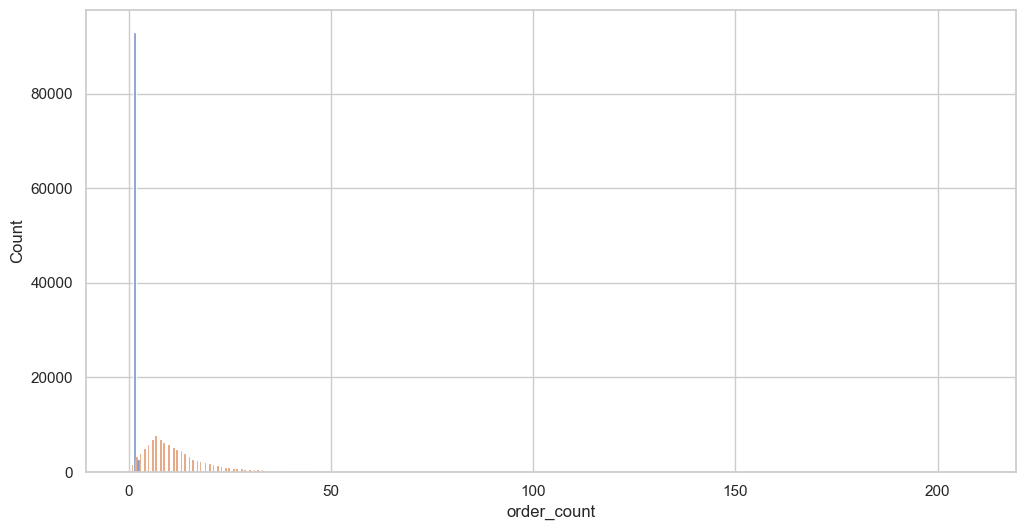

In [62]:
sns.histplot(data = lag_between_creat_delivered, x = 'create_del_fact')
plt.show()

In [63]:
delivery_mean = lag_between_creat_delivered.create_del_fact.mean()
delivery_mean

12.093604229294082

In [64]:
(lag_between_creat_delivered['create_del_fact'] > lag_between_creat_delivered['create_del_fact'].mean()).sum() / lag_between_creat_delivered['create_del_fact'].notna().sum()

0.35853633253861306

получается, дольше 12 дней доставлялось 35% заказов.
теперь сравню с ожидаемым сроком доставки

In [66]:
delivery_lag['create_del_est'] = (delivery_lag.order_estimated_delivery_date - delivery_lag.order_purchase_timestamp).dt.days

In [67]:
lag_between_creat_estimated = delivery_lag[["order_id","create_del_est", "order_status"]].query("order_status == 'delivered'")
lag_between_creat_estimated= lag_between_creat_estimated.dropna(subset=["create_del_est"])

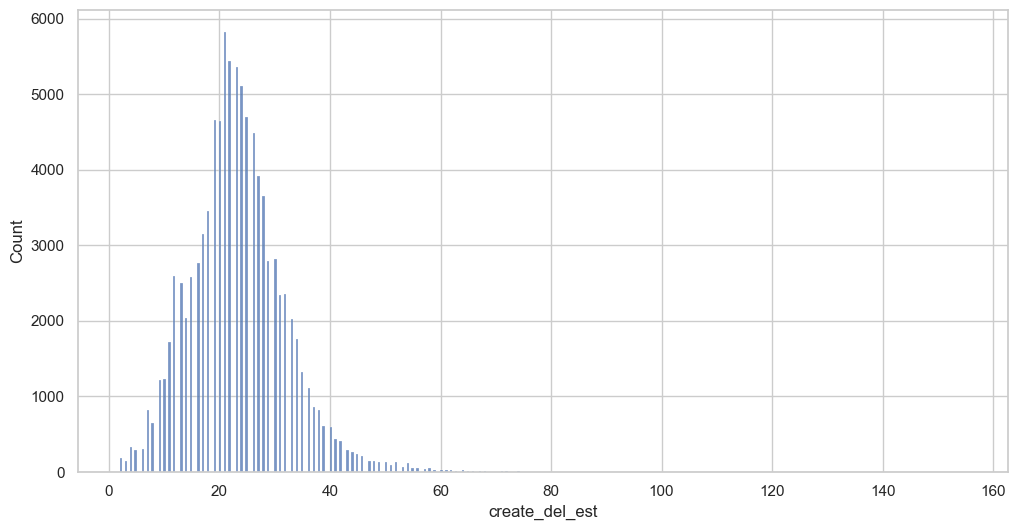

In [68]:
sns.histplot(lag_between_creat_estimated, x = "create_del_est")
plt.show()

In [69]:
delivery_est_mean = lag_between_creat_estimated.create_del_est.mean()
delivery_est_mean

23.372758556354817

получается, среднее фактическое время доставки даже меньше стать обещанной.
стало быть, длительность доставки вряд ли может быть причиной отказа от повторной покупки.

### Суммируя, что стало известно:

1. Маркетплейс товаров из Бразилии, работает преимущественно на местном рынке, штаб-квартира вероятно в Сан-Паулу, в тройке лидеров по количеству доставок также Рио-Де-Жанейру и Бело Оризонте.
3. Покупатели в значительном большинстве оформляют один заказ, больше одного заказа  - 3% покупателей
4. Средняя стоимость выполненного заказа 120 у.е. (местная валюта, вероятно, бразильский реал)
5. Средняя длительность доставки - 12 дней, средняя обещанная дата доставки - 25 дней. Больше 12 дней доставляют 35% всех заказов.
6. Доля возвратов за весь период низкая - 1.24%
7. В 90% заказов  всего 1 товарная единица.

## Задача 1: Оценить месячный retention в оформление заказа с помощью когортного анализа.

### План 
1. Определить нужный датасет: Для когортного анализа нужен датасет активности покупателей. Активность по заказам представлена в датасете orders
2. Определить, какой вид заказа будет учитываться в retention
3. Также нужно добавить к этому датасету уникальные ID клиентов из датасета customers
4. Собрать таблицу для когортного анализа, рассчитать retention
5. Посчитать среднее значение retention за первый месяц
6. Найти когорту с самым высоким retention на 3-й месяц.
7. Проиллюстрировать результаты релевантной визуализацией, удобной для восприятия.

In [74]:
# беру только доставленные заказы, а их большинство
orders_copy = orders_copy[orders_copy["order_status"] == "delivered"] 

In [75]:
# отдельно сохраню датафрейм df1 для расчета когорт 
df1 = orders_copy[["customer_id", "order_id","order_purchase_timestamp"]]

In [76]:
df1

,customer_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39
...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27


In [77]:
# добавляю к заказам уникальный ID клиентов customer_unique_id, чтобы по ним определять когорты
df1 = df1.merge(customers[["customer_id", "customer_unique_id"]], on="customer_id", how="inner")

In [78]:
df1.head(3)

,customer_id,order_id,order_purchase_timestamp,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8


In [79]:
order_count = df1.groupby('customer_unique_id').agg(order_count=('order_id', 'count'))

In [80]:
sns.histplot(order_count, x = "order_count") # еще раз взглянуть на то, что большинство клиентов делали только один заказ
plt.title('Количество заказов на одного покупателя', fontsize=16)

Text(0.5, 1.0, 'Количество заказов на одного покупателя')

In [81]:
# определяю месяц и день заказа
df1['order_period'] = df1['order_purchase_timestamp'].dt.to_period('M')
df1['order_period_day'] = df1['order_purchase_timestamp'].dt.to_period('D')

In [82]:
# задаю когорты на основе даты первого заказа для каждого клиента
df1['cohort'] = df1.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
df1['cohort_day'] = df1.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

In [83]:
df1.head(5)

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,order_period,order_period_day,cohort,cohort_day
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-10-02,2017-09,2017-09-04
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07,2018-07-24,2018-07,2018-07-24
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08-08,2018-08,2018-08-08
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11-18,2017-11,2017-11-18
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02-13,2018-02,2018-02-13


In [84]:
# рассчитываю номер периода в днях (будем считать, что в месяце 30)
df1['period_number_month'] = np.floor((df1.order_period_day - df1.cohort_day).apply(attrgetter('n')) / 30)

In [85]:
df1.head(3)

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,order_period,order_period_day,cohort,cohort_day,period_number_month
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-10-02,2017-09,2017-09-04,0.0
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07,2018-07-24,2018-07,2018-07-24,0.0
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08-08,2018-08,2018-08-08,0.0


In [86]:
# собираю данные по когортам и номеру периода
cohort = df1.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [87]:
cohort

,cohort,period_number_month,n_customers
0,2016-09,0.0,1
1,2016-10,0.0,262
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1
...,...,...,...
210,2018-06,1.0,22
211,2018-06,2.0,6
212,2018-07,0.0,5949
213,2018-07,1.0,6


In [88]:
# таблицу cohort перевожу в сводную таблицу для когортного анализа
cohort_pivot = cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [89]:
cohort_pivot

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,NaN,NaN,NaN
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# определяю размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [91]:
# вычисляю коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [92]:
retention_matrix

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN
2017-03,1.0,0.002797,0.005194,0.004395,0.001199,0.000799,0.003596,0.001598,0.002397,0.002397,...,0.001598,0.001598,0.001199,0.002797,0.000799,0.001199,0.000799,NaN,NaN,NaN
2017-04,1.0,0.003546,0.002660,0.000443,0.002660,0.003546,0.002660,0.004433,0.002216,0.002660,...,0.001330,NaN,0.000887,0.000887,0.000887,0.000887,NaN,NaN,NaN,NaN
2017-05,1.0,0.004057,0.004057,0.002318,0.003767,0.003187,0.003187,0.001159,0.002898,0.002608,...,0.003187,0.001739,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.004281,0.004939,0.003622,0.001646,0.005268,0.002963,0.001976,0.001317,0.003293,...,0.002963,0.000988,0.002963,0.001317,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
new_customers = cohort_pivot.iloc[:, 0:1] # новые покупатели
mean_new_customers = new_customers.mean()
mean_new_customers

period_number_month
0.0    4059.043478
dtype: float64

In [94]:
cohort_retention = retention_matrix.iloc[:, 1:2]  # первый месяц после регистрации
mean_retention_month1 = cohort_retention.mean()

In [95]:
mean_retention_month1

period_number_month
1.0    0.003639
dtype: float64

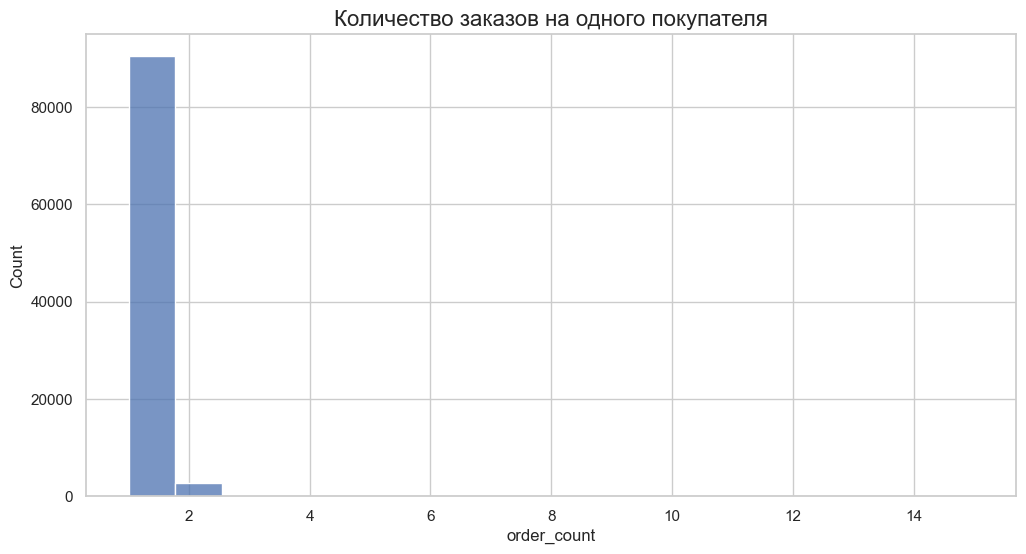

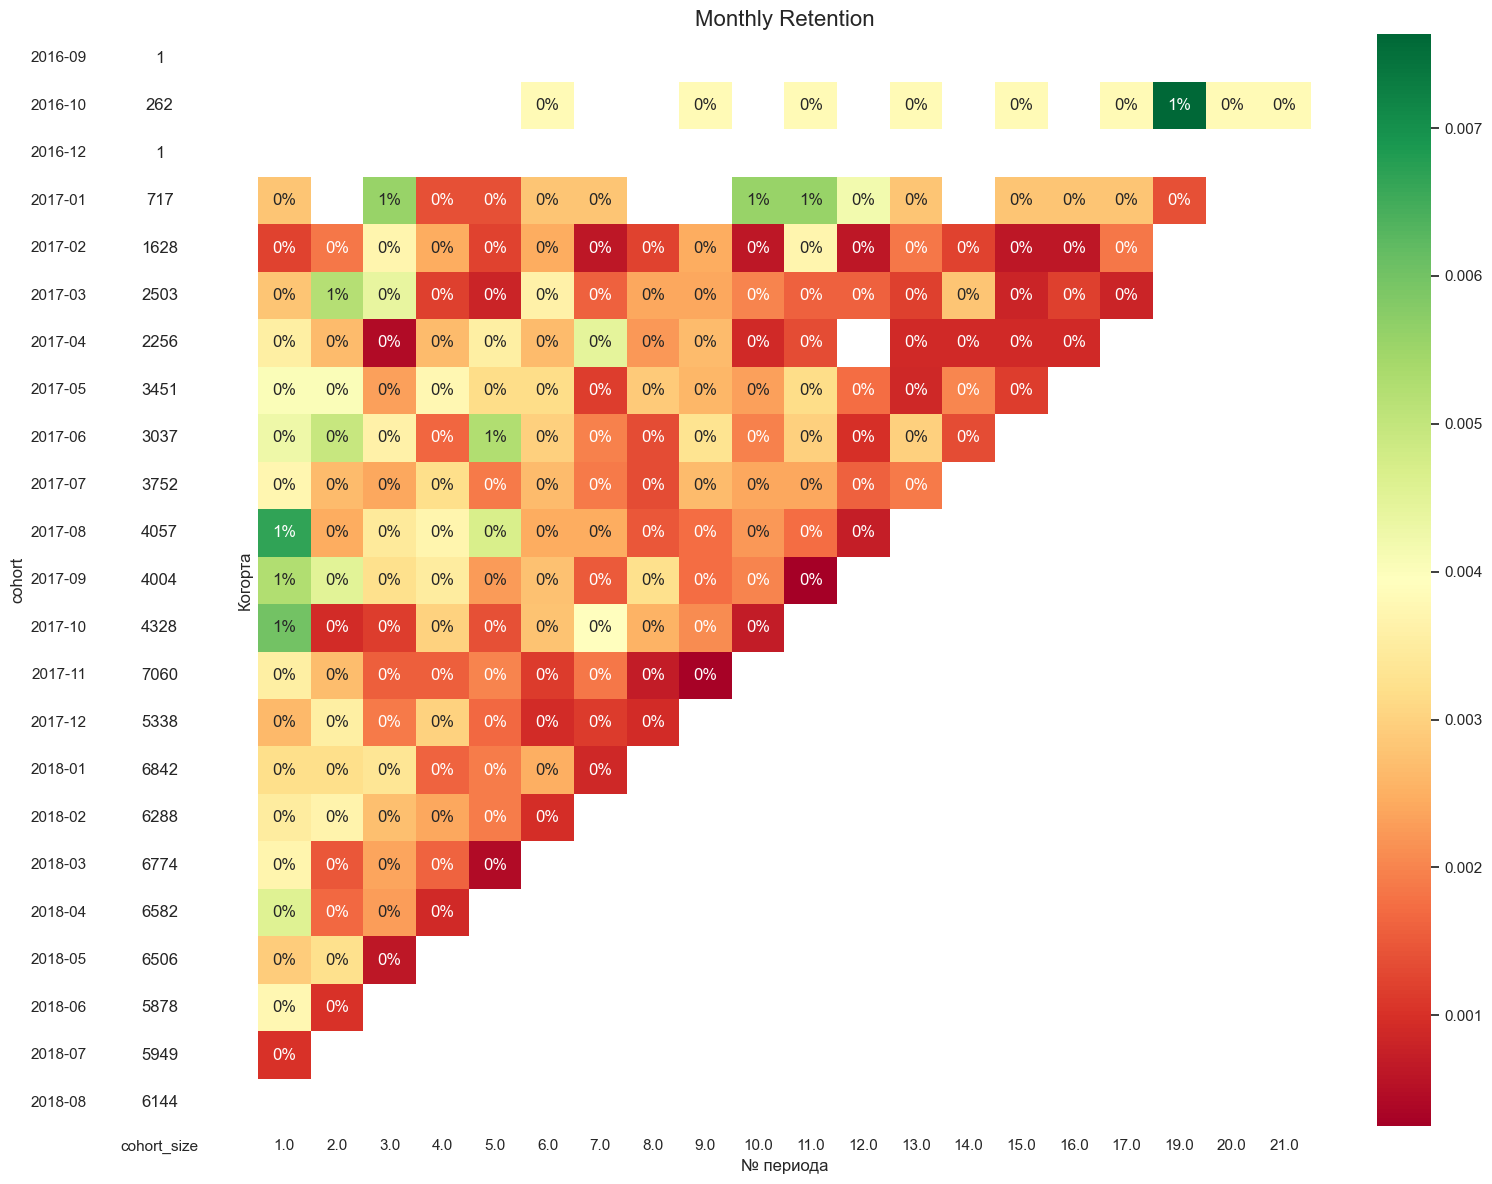

In [96]:
# Строю тепловую карту когортного анализа без нулевого месяца, потому на фоне нулевого месяца все сотальные показатели будут однотонно "красными"
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix.iloc[:, 1:],
                mask=retention_matrix.iloc[:, 1:].isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.savefig("monthly_retention.png", dpi=300, bbox_inches='tight')
    plt.show()

In [97]:
# рассчитаю средний retention за 20 месяцев
mean_retention_series = retention_matrix.mean(axis=0, skipna=True)
mean_retention_df = mean_retention_series.reset_index()
mean_retention_df.columns = ['month_number', 'avg_retention']
mean_retention_df['avg_retention'] = mean_retention_df['avg_retention']*100
mean_retention_df

,month_number,avg_retention
0,0.0,100.000000
1,1.0,0.363867
2,2.0,0.292715
3,3.0,0.264978
4,4.0,0.235020
5,5.0,0.223517
6,6.0,0.250854
7,7.0,0.201295
8,8.0,0.184559
9,9.0,0.233935


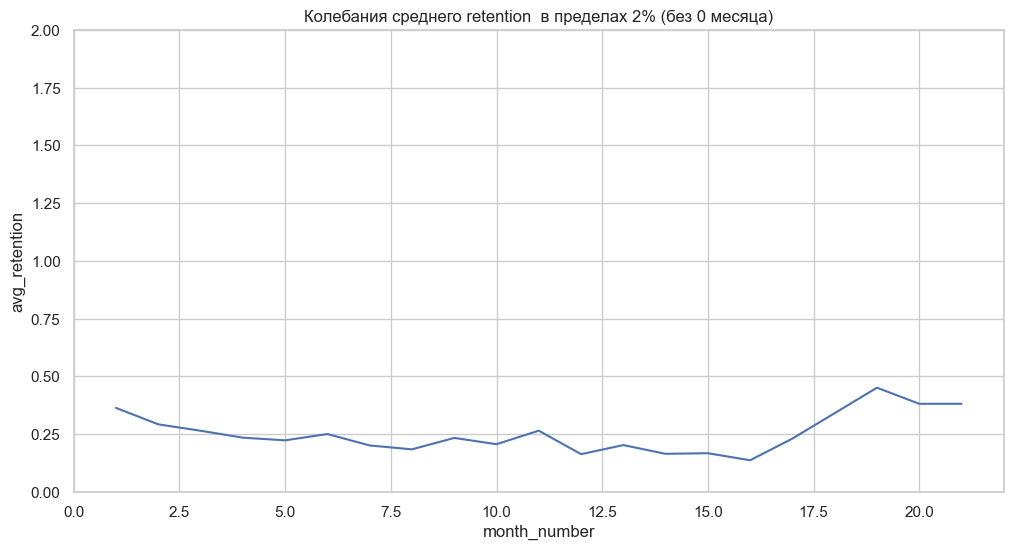

In [98]:
# график показывает флуктуацию среднего retention в пределах 0.5%
sns.lineplot(data=mean_retention_df.iloc[1:], x = "month_number",  y ="avg_retention")
plt.ylim(0, 2)  # от 0 до 2%
plt.title("Колебания среднего retention  в пределах 2% (без 0 месяца)")
plt.show()

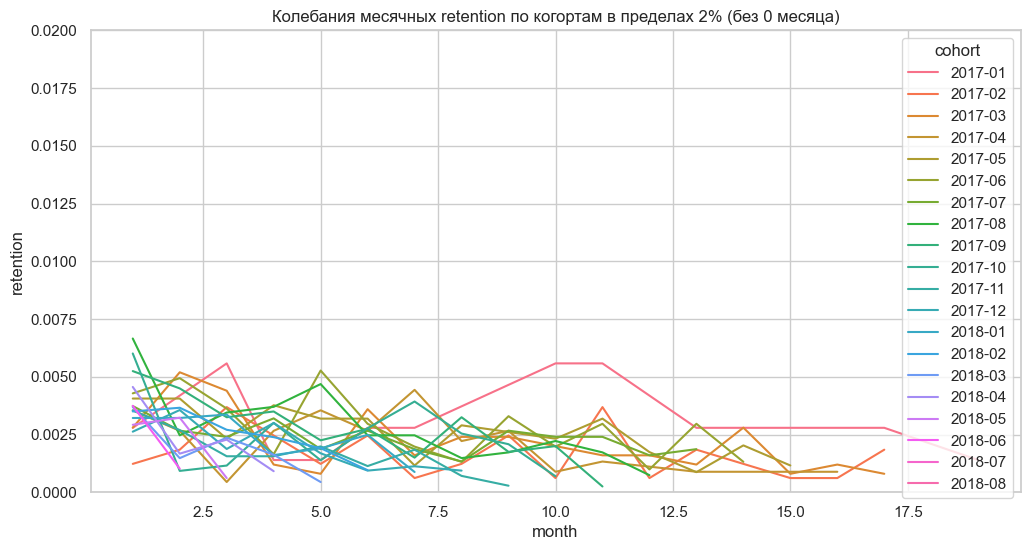

In [99]:
sns.lineplot(
    data = retention_matrix.loc["2017-01":, 1:].reset_index().melt(id_vars="cohort", var_name="month", value_name="retention"),
    x = "month", y = "retention", hue = "cohort"
)
plt.ylim(0, 0.02)  # смотрю флуктуации retention до 2%
plt.title("Колебания месячных retention по когортам в пределах 2% (без 0 месяца)")
plt.show()

In [100]:
# Усреднённый retention за первый месяц
average_retention_first_month = round(retention_matrix[1].median(), 4)
average_retention_first_month
print(f'Медианный retention за первый месяц: {average_retention_first_month:.4f}')

Медианный retention за первый месяц: 0.0035


### Задача 1. Выводы:

- Маркетплейс запустился в сентябре 2016, но маркетинг, вероятно, подключился с января 2017, и в среднем за период с января 2017 по август 2018 приводил ежемесячно 3843 новых клиента.
- Однако  все когорты демонстрируют резкое падение retention в первый же месяц, средний показатель retention 1го месяца 0.4%, лучший показатель retention первого месяца был в августе 2018 и равен 0.6655%
- Самый высокий retenton за 3й месяц был в январе 2017 и равен 0.5579%
- В большинстве когорт retention после 2-го месяца стремится к нулю, что говорит об отсутствии устойчивой пользовательской базы. Нет когорт с заметным ростом или стабильностью, все они затухают в течение 2–3 месяцев.
- Можно сделать предположение о низком product market fit

! Но такие выводы можно сделать, если для товарной линейки данного маркетплейса товаров из Бразилии предполагаемая частота покупок таких товаров - ежемесячная.
- Если же это товары длительного пользования (более двух лет, при среднем чеке 137.75 BRL (бразильских реалов) - что это может быть?), возможно retention будет более показателен на более длинных периодах времени.
- Также нужно помнить о низком проценте возвратов (1.2%) и сроке доставки, почти вдвое ниже обещанного - тогда можно предположить, что неудовлетворенность качеством товаров и сервиса не должны быть причиной низких показателей месячного retention.


## Задача 2: Определить, существует ли product/market fit у этого маркетплейса.

### Задание
Построив retention, вы решили оценить, насколько хорошо продукт закрывает потребности клиента.
Для этого вам нужно:
- Определить, существует ли product/market fit у этого маркетплейса. Ведь до сих пор непонятно, можно ли масштабировать подобный продукт на новые рынки. Есть вероятность, что маркетплейс будет приносить убытки.

    В рамках исследования необходимо:

- Оценить наличие product/market fit у данного продукта с помощью когортного анализа, полученного на предыдущем шаге.
- Пояснить свою позицию и сформулировать, на чём маркетплейс должен сконцентрироваться в ближайшее время. 
    - Если PMF есть, то в какую сторону лучше развивать продукт дальше? 
    - Если PMF нет, то какие причины могут быть у этого?
- Подкрепить свои выводы релевантной визуализацией, удобной для восприятия.

### Задача 2. Выводы:

1. **Определить, существует ли product/market fit у этого маркетплейса**

Если принять тот факт, что для товаров маркетплейса предполагаемая частота покупок должна быть ежемесячная, а значит месячный retention отражает возвращаемость к покупкам товаров, то когорный анализ показывает **низкий retention**, стремящийся к нулю с первого же месяца. 
Это говорит о том, что после первой покупки клиенты (почти) не возвращаются в маркетплейс за повторными покупками. В свою очередь, это может свидетельствовать о **низком product market fit, и продукт пока не готов к масштабированию**.

**Однако**, также стоит отметить количество новых клиентов, совершивших заказ в нулевой период, среднее количество новых пользователей (за весь период) в месяц равно 4059.
Вкупе с низким процентом отмененных заказов (1.2% от общего числа заказов) это говорит о том, что спрос есть (жаль, что нет информации о конверсии в покупку), люди покупают и не возвращают товары, то есть можно предположить, что не уходят разочарованными.

2. **Причины низкого product/market fit**
   
Чтобы рассуждать о причинах отсутствия product market fit, нужно сделать предположение о предлагаемых товарных категориях маркетплейса.
Известно, что средняя стоимость заказа 137.75 BRL, средняя стоимость товара 120.65 BRL, максимальная стоимость товара 6735.00 BRL

1. Если опираться на среднюю стоимость заказа в 137.75 BRL,  вероятнее всего речь идет о мелкой бытовой технике, посуде, утвари. Для retail'а хороший показатель годового retention может составлять до 63% (https://explodingtopics.com/blog/customer-retention-rates?utm_source=chatgpt.com).

Тогда причинами низкого PMF могут быть:
- Редкая потребность в повторной покупке
- Первый пользовательский опыт покупки был негативный
- Отсутствие допродаж, триггеров для возвращения (рассылка, карты лояльности)

Возможно retention не совсем подходит в качестве основной метрики.

2. Если опираться на показания  retention (что не совсем корректно, потому что не только тип товара влияет на покупательский спрос и возвращаемость клиентов), то товары маркетплейста могут быть долгого или разового использования с высоким value-per-use. Например, сувениры, предметы интерьера, картины.

В этом случае, причинами низкого PMF могут быть:
    - собственно специфика самого товара, когда нет потребности покупать его еще. не предполагается какая-то регулярность его использования. 
    - ценность покупки в первом опыте, а не в постоянстве.
    - также, может быть дополнительной причиной недостаточная работа над лояльностью - рассылки о новых товарах. но тут сложно судить в отсутствие информации о посещениях/просмотрах.


В обоих случаях product/market fit определять не по месячному retention в последующие покупки, а также по другим метрикам, например, конверсия в первую покупку, NPS (рекомендации) и виральность (покупки по реферальным ссылкам), удовлетворенность покупкой CSAT,



In [105]:
items.price.mean()

120.65373901464716

In [106]:
items.product_id.nunique()

32951

In [107]:
items.price.max()

6735.0

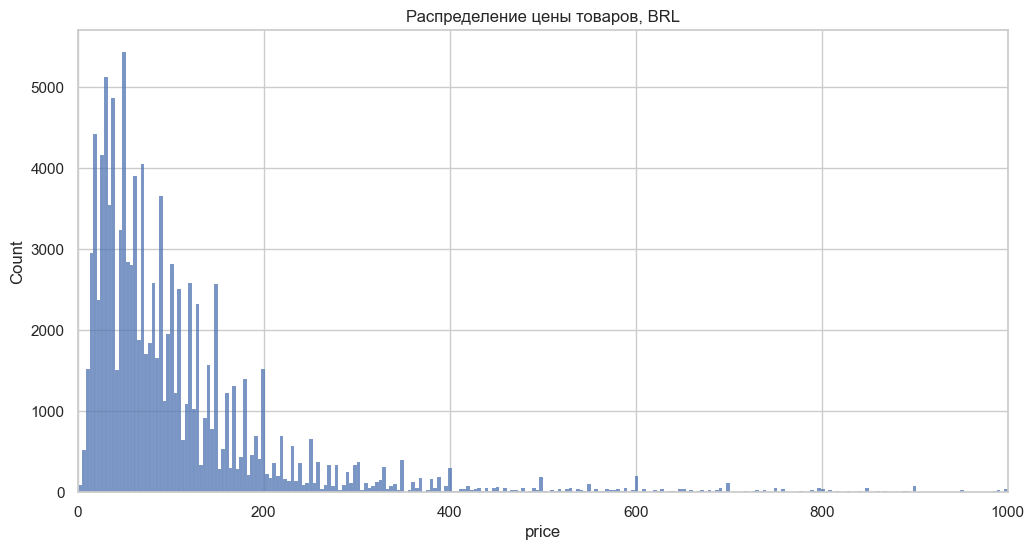

In [108]:
# распредедение цены товаров, большинство товаров стоимости до 200BRL
sns.histplot(items, x = "price")
plt.xlim(0, 1000)
plt.title('Распределение цены товаров, BRL')
plt.show()

## Задача 3. Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании

### Задание
Вы разобрались с наличием product/market fit. Теперь вас просят сформулировать продуктовые метрики маркетплейса, чтобы компания могла на них ориентироваться.

В первую очередь необходимо:

Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.
1. Первая метрика должна отражать рост объёма продаж маркетплейса.
2. Вторая — показывать объем аудитории, которой продукт доставляет ценность.
3. Третья — отражать заинтересованность новых клиентов в продукте (даже если вы не можете посчитать ее на имеющихся у вас данных).
4. Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.
5. Пятая — отражать денежное выражение вовлеченности клиента.
Визуализируйте первую, вторую, четвёртую и пятую метрики. Используйте месячную гранулярность и окно в 1 месяц, если это нужно.

### 3.1. Метрика, отражающая рост объема продаж

Объем продаж Gross Value = количество покупателей * средний чек
Скачаю таблицу покупателей по когортам и посчитаю их количество на каждый месяц, начиная с января 2017 по август 2018, в excel

In [113]:
cohort_pivot.to_csv('cohort_pivot.csv')

In [114]:
null_month = pd.read_csv('null_month.csv')

In [115]:
null_month['revenue'] = null_month['customers_count']*revenue_per_user

In [116]:
null_month

,month,customers_count,revenue
0,0,717,86040.0
1,1,1630,195600.0
2,2,2505,300600.0
3,3,2270,272400.0
4,4,3479,417480.0
5,5,3073,368760.0
6,6,3787,454440.0
7,7,4108,492960.0
8,8,4083,489960.0
9,9,4396,527520.0


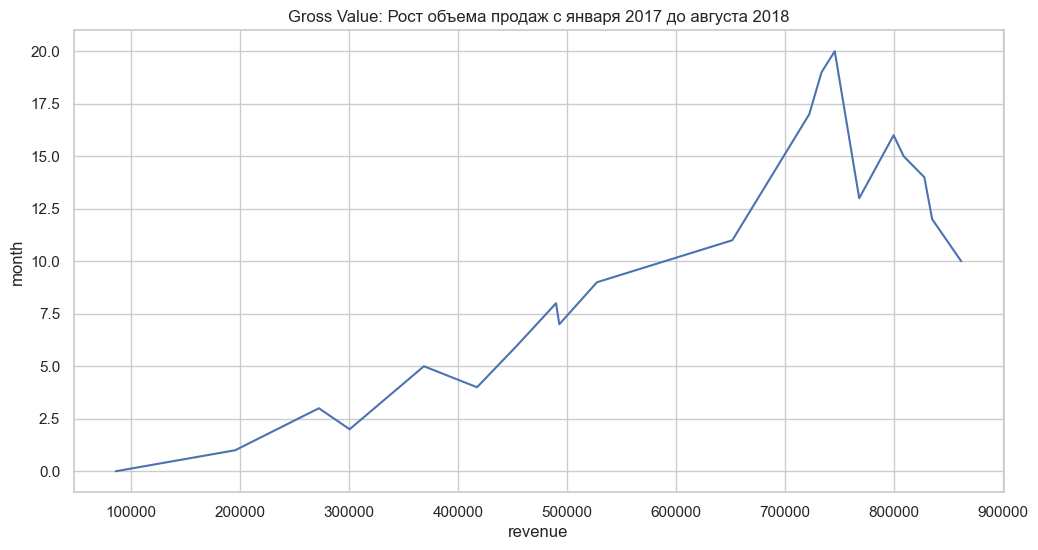

In [117]:
sns.lineplot(null_month, x= 'revenue', y = 'month') # график роста объема продаж с января 2017
plt.title("Gross Value: Рост объема продаж с января 2017 до августа 2018")
plt.savefig("gross_value.png", dpi=300, bbox_inches='tight')
plt.show()

### 3.2. Объем аудитории, которой продукт доставляет ценность

Очевидно, речь идет  об объеме аудитории покупателей, оформивших и получивших свои заказы.
Назовем метрику Monthly Active Buyers

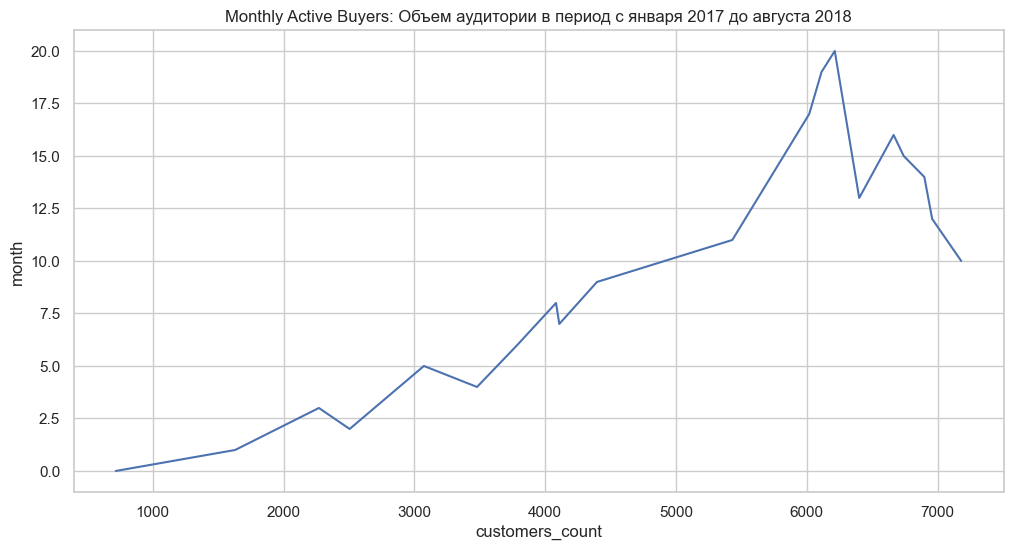

In [120]:
sns.lineplot(null_month, x= 'customers_count', y = 'month') # график роста объема продаж с января 2017
plt.title("Monthly Active Buyers: Объем аудитории в период с января 2017 до августа 2018")
plt.show()

### 3.3 Заинтересованность новых клиентов в продукте (даже если вы не можете посчитать ее на имеющихся у вас данных).

Речь идет, вероятно, о конверсии из посетителей в первую покупку.
Расчитывается как (количество новых посетителей маркетплейса)/(количество новых посетителей, оформивших покупку)

### 3.4 Вовлеченность клиента в продолжение использования продукта

Речь идет о retention, такой график я строила выше:

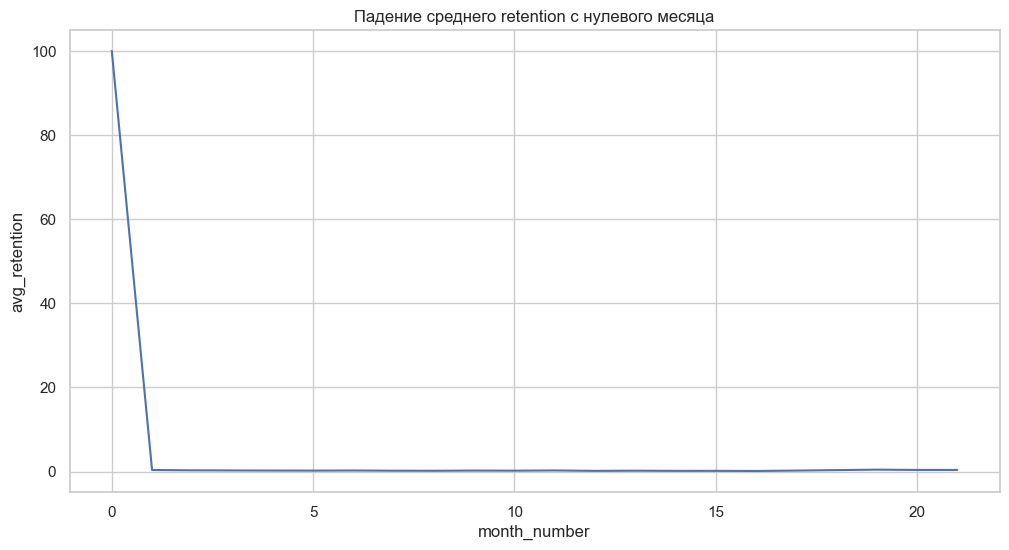

In [125]:
sns.lineplot(data=mean_retention_df, x = "month_number",  y ="avg_retention")
plt.title("Падение среднего retention с нулевого месяца")
plt.show()

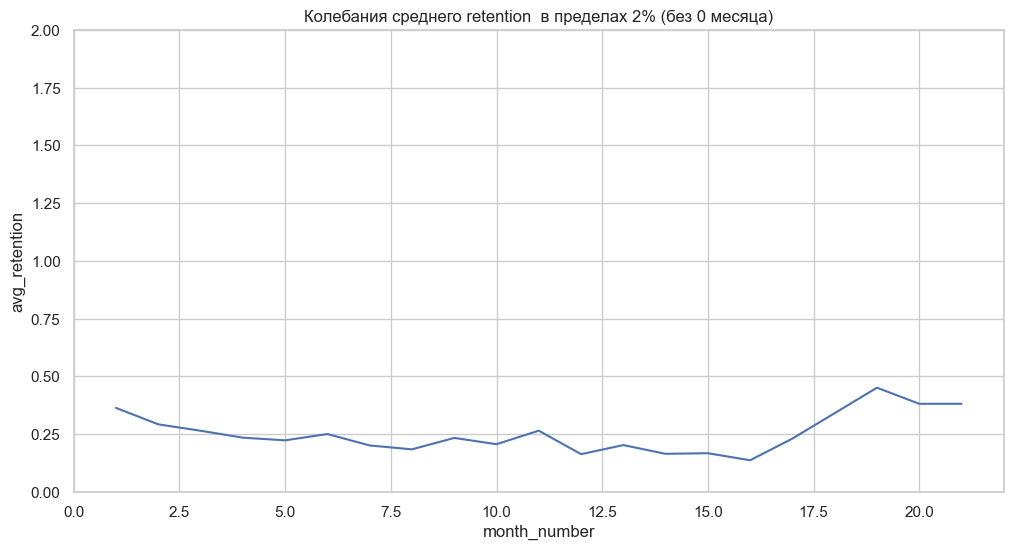

In [126]:
# график показывает флуктуацию среднего retention в пределах 0.5%
sns.lineplot(data=mean_retention_df.iloc[1:], x = "month_number",  y ="avg_retention")
plt.ylim(0, 2)  # от 0 до 2%
plt.title("Колебания среднего retention  в пределах 2% (без 0 месяца)")
plt.show()

### 3.5 Денежное выражение вовлеченности клиента

Метрика отражает общую выручку, которую компания получает с одного клиента в среднем, average revenue per paying user over lifetime (ARPPU), накопленная денежная вовлеченность

In [129]:
arppu_df = df1.merge(items[['order_id', 'price']], on='order_id')
arppu_df

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,order_period,order_period_day,cohort,cohort_day,period_number_month,price
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-10-02,2017-09,2017-09-04,0.0,29.99
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07,2018-07-24,2018-07,2018-07-24,0.0,118.70
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08-08,2018-08,2018-08-08,0.0,159.90
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11-18,2017-11,2017-11-18,0.0,45.00
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02-13,2018-02,2018-02-13,0.0,19.90
...,...,...,...,...,...,...,...,...,...,...
110192,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02-06,2018-02,2018-02-06,0.0,174.90
110193,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08-27,2017-08,2017-08-27,0.0,205.99
110194,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01-08,2018-01,2018-01-08,0.0,179.99
110195,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01-08,2018-01,2018-01-08,0.0,179.99


In [130]:
monthly_revenue = arppu_df.groupby('order_period').agg(
    total_revenue=('price', 'sum'),
    paying_users=('customer_unique_id', 'nunique')).reset_index()

monthly_revenue['ARRPU'] = monthly_revenue['total_revenue'] / monthly_revenue['paying_users']
monthly_revenue[['order_period', 'total_revenue', 'paying_users', 'ARRPU']]

,order_period,total_revenue,paying_users,ARRPU
0,2016-09,134.97,1,134.970000
1,2016-10,40325.11,262,153.912634
2,2016-12,10.90,1,10.900000
3,2017-01,111798.36,718,155.708022
4,2017-02,234223.40,1630,143.695337
5,2017-03,359198.85,2508,143.221232
6,2017-04,340669.68,2274,149.810765
7,2017-05,489338.25,3479,140.654858
8,2017-06,421923.37,3076,137.166245
9,2017-07,481604.52,3802,126.671362


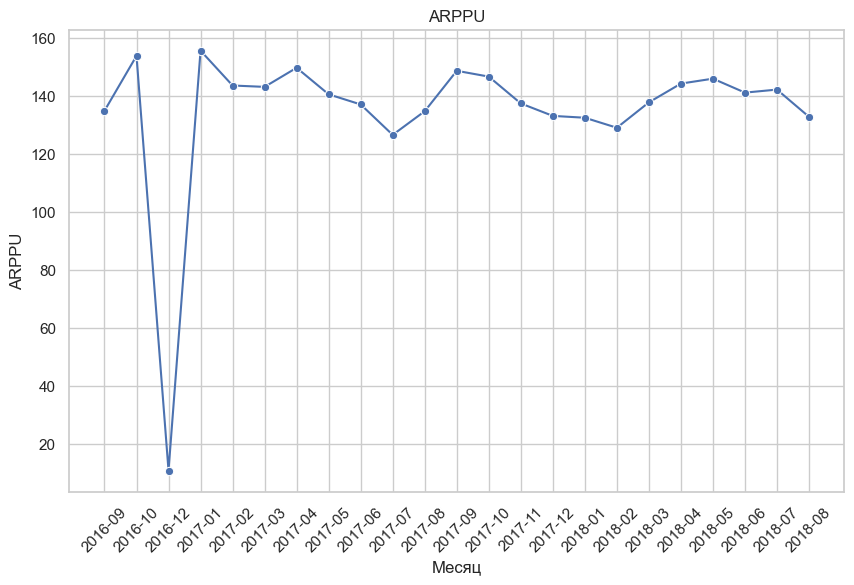

In [131]:
monthly_revenue['order_period'] = monthly_revenue['order_period'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_revenue, x='order_period', y='ARRPU', marker='o')
plt.title('ARPPU')
plt.xlabel('Месяц')
plt.ylabel('ARPPU')
plt.xticks(rotation=45)

plt.show()

## Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Посмотрев с продактом на когортный анализ и метрики, вы решили, что нужно изменить продукт. Метрики необходимо срочно повышать. Вместе с командой вы сформулировали 3 гипотезы, в которые вы верите. По каждой гипотезе команда заполнила показатели по Ease, Confidence. Вам нужно заполнить самый важный показатель — Impact. Для этого вам требуется:

Выбрать одну из трёх основных гипотез с помощью фреймворка ICE, которые были сформированы продактом и, кажется, должны улучшить пользовательский опыт в маркетплейсе.

Для расчёта Impact возьмите данные с июня 2017 года. Считайте, что конверсия в повторный заказ равна величине медианного retention 1-го месяца (см. пункт 1 проекта).

### Гипотезы
1. Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен
2. Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов.
3. Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов тех, кто раньше не делал повторный заказ.

#### Гипотеза 1 
    "Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен"

Посчитаю количество заказов в статусе canceled и  unavailable, их сумма даст импакт по гипотезе 1

In [136]:
orders.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [137]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [138]:
count_canceled = orders[(orders.order_purchase_timestamp >= '2017-06') &
                        (orders.order_status.isin(['canceled', 'unavailable']))].order_id.nunique()
count_canceled

974

согласно таблице, это количество недополученных пользователей соответствует метрике 5

In [140]:
Impact1 = 5

#### Гипотеза 2 
    "Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов."

Согласно https://blog.bvmagazine.com.br/prazo-medio-de-entrega/ средний срок доставки ритейла в Бразилии составляет 18 дней, на юге страны до 14 дней.
Согласно моим расчетам, фактическое время доставки  маркеплейса 12 дней, что меньше обещанного 24 дня.
С одной стороны, возможно покупаетелей отталкивает изначально обещанный долгий срок доставки, с другой стороны, это низкие ожидания могут компенсироваться более скорой доставкой.
Если маркетплейс располагает ресурсами драматически ускорить доставку, это может быть конкурентным преимуществом.

Однако, в формулировке гипотезы сказано о получении заказов с запаздыванием - то есть сроком больше обещанного.
Умозрительно, доля таких заказов невелика (дольше 12 дней доставлялось 35% заказов), поэтому такое изменение не даст заметного увеличения объема повторых заказов.

In [142]:
delivery_compare  = orders_copy[["order_id", "order_status", "order_delivered_carrier_date", "order_estimated_delivery_date","order_purchase_timestamp"]]

In [143]:
delivery_compare = delivery_compare[delivery_compare["order_status"] == 'delivered']

In [144]:
delivery_compare = delivery_compare[delivery_compare["order_purchase_timestamp"] >= '2017-06']

In [145]:
delivery_compare

,order_id,order_status,order_delivered_carrier_date,order_estimated_delivery_date,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-04 19:55:00,2017-10-18,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-26 14:31:00,2018-08-13,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 13:50:00,2018-09-04,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-22 13:39:59,2017-12-15,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-14 19:46:34,2018-02-26,2018-02-13 21:18:39
...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,delivered,2017-10-05 16:52:52,2017-11-07,2017-10-04 19:57:37
99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-07 23:22:42,2018-03-02,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-28 20:52:26,2017-09-27,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,delivered,2018-01-12 15:35:03,2018-02-15,2018-01-08 21:28:27


In [146]:
delivery_compare['order_delivered_carrier_date'] = delivery_compare.order_delivered_carrier_date.dt.date

In [147]:
delivery_compare['order_estimated_delivery_date'] = delivery_compare.order_estimated_delivery_date.dt.date

In [148]:
delivery_compare

,order_id,order_status,order_delivered_carrier_date,order_estimated_delivery_date,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-04,2017-10-18,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-26,2018-08-13,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08,2018-09-04,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-22,2017-12-15,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-14,2018-02-26,2018-02-13 21:18:39
...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,delivered,2017-10-05,2017-11-07,2017-10-04 19:57:37
99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-07,2018-03-02,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-28,2017-09-27,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,delivered,2018-01-12,2018-02-15,2018-01-08 21:28:27


In [149]:
delivery_compare[delivery_compare.order_delivered_carrier_date > delivery_compare.order_estimated_delivery_date].order_id.nunique()

298

0.3% - доля заказов, которые были доставлены позже обещанного. сокращение этой доли пользователей даст незначительный прирост оборота.

#### Гипотеза 3 
    "Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов тех, кто раньше не делал повторный заказ."

    Также дано: Для расчёта Impact возьмите данные с июня 2017 года. Считайте, что конверсия в повторный заказ равна величине медианного retention 1-го месяца (см. пункт 1 проекта).

Возьму эту гипотезу, как наиболее жизнеспособную.

Метрика, на которую хотим влиять: конверсия в повторную покупку, retention последующих месяцев

Для расчета Impact по этой гипотезе можно посчитать количество заказов, где клиент сделал только единичный заказ. Конверсию в повторный заказ возьмем равной 0.0035.

In [209]:


orders_succesessful = orders[(orders.order_purchase_timestamp >= '2017-06') &
                        (~orders.order_status.isin(['canceled', 'unavailable']))]
successful_orders_transf = successful_orders.merge(customers[['customer_id', 'customer_unique_id']],
                                                 on='customer_id',
                                                 how='left')
successful_orders_transf

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...,...,...,...,...,...,...
86606,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07 00:00:00,c716cf2b5b86fb24257cffe9e7969df8
86607,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660
86608,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30
86609,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c


In [213]:
# Подсчитываем количество заказов для каждого клиента
customer_order_counts = successful_orders_transf.groupby('customer_unique_id').order_id.nunique().reset_index()

# Определяем количество клиентов, которые сделали только один заказ
single_order_customers_count = (customer_order_counts == 1).order_id.sum()

customer_order_counts.groupby('order_id').nunique('customer_unique_id')

In [217]:
print(f'Количество задержанных заказов: {single_order_customers_count}')
print(f'Возможное количество повторных заказов: {single_order_customers_count*0.0035}')

Количество задержанных заказов: 81641
Возможное количество повторных заказов: 285.7435


По приложенной таблице этот score равен 2
ICE-score 

In [220]:
ICE_score = 2*5*9
print(f'ICE score гипотезы 3 = {ICE_score}')

ICE score гипотезы 3 = 90


Гипотеза 1 имеет наибольший приоритет.

## Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять

Гипотезу 1  можно реализовать для  улучшения метрик компании. 
Попробую A/B-тестирование для проверки её эффективности.

План:
- Сформулировать метрики, на которые должна повлиять гипотеза.
- Сформулировать метрики в категории: целевые, прокси, guardrail и объяснить свой выбор.

### Выбор метрик для гипотезы 1

    "Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен"

#### Целевые метрики
- Доля доставленных заказов = доставленные / все заказы
#### Прокси метрики
- Доля заказов с отменой по инициативе клиента
- Доля заказов отмененных по операционным причинам
- Количество обращений в поддержку по поводу отмен

#### Guardrail метрики
- Время доставки
- Доля возвратов заказов, оплаченных новым методом
- Payment Error Rate или похожая техническая метрика, замеряющая долю сессий с ошибками - в целом, и связанная с новым методом оплаты
- Доля незавершенных оплат и доля незавершенных оплат новым методом